<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/time_frequency_erds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [6]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.1 MB/s eta 0:00:00




# Compute and visualize ERDS maps

This example calculates and displays ERDS maps of event-related EEG data. ERDS
(sometimes also written as ERD/ERS) is short for event-related
desynchronization (ERD) and event-related synchronization (ERS)
:footcite:`PfurtschellerLopesdaSilva1999`. Conceptually, ERD corresponds to a
decrease in power in a specific frequency band relative to a baseline.
Similarly, ERS corresponds to an increase in power. An ERDS map is a
time/frequency representation of ERD/ERS over a range of frequencies
:footcite:`GraimannEtAl2002`. ERDS maps are also known as ERSP (event-related
spectral perturbation) :footcite:`Makeig1993`.

In this example, we use an EEG BCI data set containing two different motor
imagery tasks (imagined hand and feet movement). Our goal is to generate ERDS
maps for each of the two tasks.

First, we load the data and create epochs of 5s length. The data set contains
multiple channels, but we will only consider C3, Cz, and C4. We compute maps
containing frequencies ranging from 2 to 35Hz. We map ERD to red color and ERS
to blue color, which is customary in many ERDS publications. Finally, we
perform cluster-based permutation tests to estimate significant ERDS values
(corrected for multiple comparisons within channels).


In [7]:
# Authors: Clemens Brunner <clemens.brunner@gmail.com>
#          Felix Klotzsche <klotzsche@cbs.mpg.de>
#
# License: BSD-3-Clause

As usual, we import everything we need.



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

First, we load and preprocess the data. We use runs 6, 10, and 14 from
subject 1 (these runs contains hand and feet motor imagery).



In [9]:
fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']


Now we can create 5s epochs around events of interest.



In [11]:
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original time points ...
0 bad epochs dropped


Here we set suitable values for computing ERDS maps.



In [12]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

Finally, we perform time/frequency decomposition over all epochs.



In [14]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


ValueError: ignored

Similar to `~mne.Epochs` objects, we can also export data from
`~mne.time_frequency.EpochsTFR` and `~mne.time_frequency.AverageTFR` objects
to a :class:`Pandas DataFrame <pandas.DataFrame>`. By default, the `time`
column of the exported data frame is in milliseconds. Here, to be consistent
with the time-frequency plots, we want to keep it in seconds, which we can
achieve by setting ``time_format=None``:



In [15]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C3,Cz,C4
0,-1.0000,2.0,0,feet,1.868006e-08,2.416446e-08,9.245538e-09
1,-0.9875,2.0,0,feet,1.802184e-08,2.391070e-08,9.307263e-09
2,-0.9750,2.0,0,feet,1.769524e-08,2.440337e-08,9.817562e-09
3,-0.9625,2.0,0,feet,1.770470e-08,2.532329e-08,1.062991e-08
4,-0.9500,2.0,0,feet,1.716206e-08,2.559621e-08,1.098840e-08


This allows us to use additional plotting functions like
:func:`seaborn.lineplot` to plot confidence bands:



Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


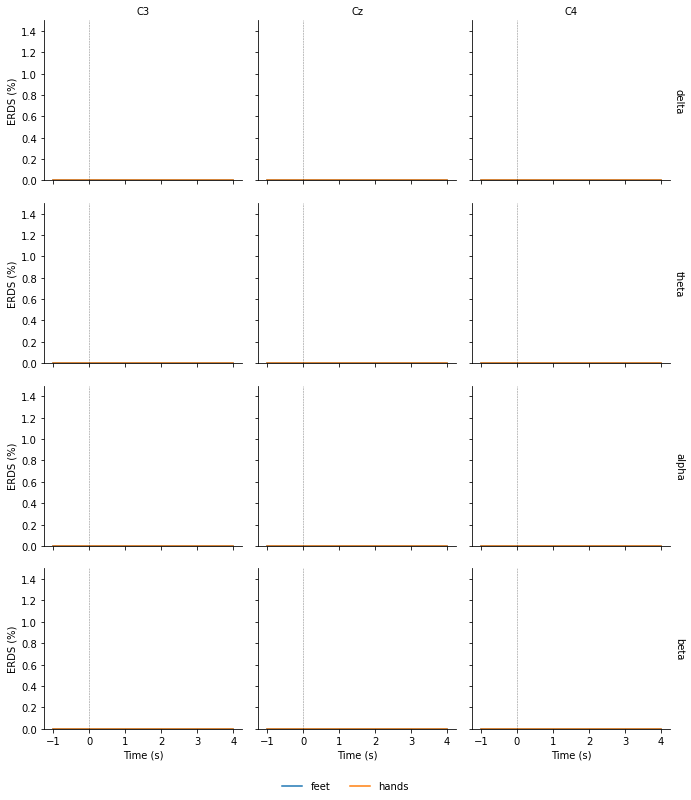

In [16]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Having the data as a DataFrame also facilitates subsetting,
grouping, and other transforms.
Here, we use seaborn to plot the average ERDS in the motor imagery interval
as a function of frequency band and imagery condition:



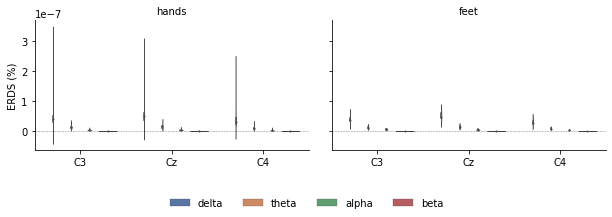

In [17]:
df_mean = (df.query('time > 1')
             .groupby(['condition', 'epoch', 'band', 'channel'])[['value']]
             .mean()
             .reset_index())

g = sns.FacetGrid(df_mean, col='condition', col_order=['hands', 'feet'],
                  margin_titles=True)
g = (g.map(sns.violinplot, 'channel', 'value', 'band', n_boot=10,
           palette='deep', order=['C3', 'Cz', 'C4'],
           hue_order=freq_bands_of_interest,
           linewidth=0.5).add_legend(ncol=4, loc='lower center'))

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

## References
.. footbibliography::

